In [2]:
# !pip install pyphen
# !pip install --upgrade shap
# !pip install numpy==1.23

In [2]:
import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec

import gensim

from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument

from sklearn.model_selection import KFold

from sklearn.base import clone as sklearn_clone

from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

import matplotlib.pyplot as plt

# import spacy
from sentimentpl.models import SentimentPLModel
from autocorrect import Speller

import re
import unicodedata

from tqdm.notebook import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=7,progress_bar=True)

from parallelbar import progress_map

import pyphen
import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from xgboost import XGBClassifier

import seaborn as sns
import scipy
import shap

from sklearn.inspection import permutation_importance

# nlp_core = spacy.load("pl_core_news_lg")
# model_sent = SentimentPLModel(from_pretrained='latest')
# spell = Speller('pl')
# syllab = pyphen.Pyphen(lang='pl')
# stopwords = nlp_core.Defaults.stop_words

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Lodad data

In [3]:
df_topics = pd.read_csv('../datasets/ready2use/topics.csv', index_col=0)
df_topics.shape

(6541, 1)

In [4]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_combined.csv', sep=';')

df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

y_train = df.copy()['assestment'][df.index.isin(df_topics.index)]

X_train = df.copy()[['text_clean']][df.index.isin(df_topics.index)]

X_train['text_clean'] = X_train['text_clean'].apply( 
    lambda x:
    (x
     .replace('\n', ' ')
     .replace('ą', 'ą')
     .replace('ć', 'ć')
     .replace('ę', 'ę')
     .replace('ń', 'ń')
     .replace('ó', 'ó')
     .replace('ś', 'ś')
     .replace('ź', 'ź')
     .replace('ż', 'ż'))
)

In [5]:
y_train.shape

(6541,)

In [6]:
X_train.shape

(6541, 1)

In [7]:
X_train = pd.read_parquet('../datasets/ready2use/stylo_f_pl_dataset.parquet')
X_train.shape

(6541, 28)

### Get POS ngrams data

In [8]:
X_pos = pd.read_parquet('../datasets/ready2use/pos_pl_dataset.parquet')
X_pos.shape

(6541, 13668)

In [9]:
# keep only columns with corr > 0.05
col_keep = []
for c in tqdm(X_pos.columns):
    min_v =X_pos[c].values.min()
    max_v = X_pos[c].values.max()

    if min_v < max_v:
        r = scipy.stats.pearsonr(X_pos[c].values, y_train)[0]
        if ~np.isnan(r) and r > 0.05:
            col_keep.append(c)

if len(col_keep) == 0:
    print('No values returned')

X_pos = X_pos[col_keep]
X_pos.shape

  0%|          | 0/13668 [00:00<?, ?it/s]

(6541, 49)

### Kfold

In [10]:
cv_fold = []
cv_fold_i = []

for i in df_topics['topic'].unique().reshape(10,-1):
    train_cv = df_topics.index[ ~np.isin(df_topics["topic"], i) ].values
    test_cv = df_topics.index[ np.isin(df_topics["topic"], i) ].values
    
    train_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], i) ].values
    test_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], i) ].values
    
    cv_fold.append( [train_cv, test_cv])
    cv_fold_i.append( [train_cv_i, test_cv_i])

In [11]:
# cv_fold_rev = []
# cv_fold_rev_i = []

# for i in df_topics['topic'].unique().reshape(10,-1):
#     train_cv = df_topics.index[ np.isin(df_topics["topic"], i) ].values
#     test_cv = df_topics.index[ ~np.isin(df_topics["topic"], i) ].values
    
#     train_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], i) ].values
#     test_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], i) ].values
    
#     cv_fold_rev.append( [train_cv, test_cv])
#     cv_fold_rev_i.append( [train_cv_i, test_cv_i])

In [12]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(df_topics)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(df_topics):
    train_cv = df_topics.iloc[ train_index, : ].index.values
    test_cv = df_topics.iloc[ test_index, : ].index.values

    train_cv_i= df_topics.reset_index().iloc[ train_index, : ].index.values
    test_cv_i = df_topics.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, test_cv])
    cv_Kfold_i.append( [train_cv_i, test_cv_i])

## Experiments

In [35]:
def run_experiment(X, y, cv, clf_org, scal=None, coef=True, shap_use=None):

    results = {
        'test_accuracy' : [],
        'test_precision' : [],
        'test_recall' : [],
        'test_f1' : []
    }
    coef_matrix = []
    c_matrix = np.zeros((2,2))
    
    # shap_list_0 = []
    # shap_list_1 = []
    
    shap_list = []
    X_list = []
    per_list = []

    for train_cv, test_cv in tqdm(cv):
        clf = sklearn_clone(clf_org)
                
        y_train_t, X_train_t = y[X.index.isin(train_cv)], X[X.index.isin(train_cv)]
        y_test_t, X_test_t = y[X.index.isin(test_cv)], X[X.index.isin(test_cv)]
        
        if scal == 'std':
            scaler = StandardScaler()
        elif scal == 'minmax':
            scaler = MinMaxScaler()
        
        if scal:
            scaler.fit(X_train_t)
            X_train_t = scaler.transform(X_train_t)
            X_test_t = scaler.transform(X_test_t)
        
        clf.fit(X_train_t, y_train_t)

        y_pred = clf.predict(X_test_t)
        
        if coef:
            coef_matrix.append(clf.coef_)
        else:
            coef_matrix.append(clf.feature_importances_.reshape(1,-1))
        
        confusion = confusion_matrix(y_test_t, y_pred)
        c_matrix += confusion

        results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
        results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
        results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
        results['test_f1'].append( f1_score(y_test_t, y_pred) ) 
        
        if shap_use:
            if isinstance(shap_use, shap.TreeExplainer):
                explainer = shap_use(clf)
            else:
                explainer = shap_use(clf, X_test_t)
                
            shap_values = explainer.shap_values(X_test_t)
            
            if len(shap_values) == 2:
                shap_values = shap_values[0]
                
            shap_list.append(  shap_values )   
            X_list.append( X_test_t )
            
        result = permutation_importance(
            clf, X_test_t, y_test_t, n_repeats=10, random_state=42, n_jobs=2
        )
        per_list.append(result['importances'].T)

    metrics = {
        "Accuracy": np.array(results['test_accuracy']),
    #     "Precision": np.array(results['test_precision']).mean(),
    #     "Recall": np.array(results['test_recall']).mean(),
        "F1 Score":  np.array(results['test_f1']),
        }
    
    if shap_use:
        return metrics, np.concatenate(coef_matrix, 0), np.concatenate(shap_list, axis=0), np.concatenate(X_list, axis=0), np.concatenate(per_list, axis=0)
    
    return metrics, np.concatenate(coef_matrix, 0), per_list

In [36]:
col_use = X_train.columns[1:].values.tolist()

col_use.remove('p_adj')
col_use.remove('p_adv')
col_use.remove('p_noun')

#col_use

In [37]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

In [38]:
out, m, sh, x_sh, p = run_experiment(X_train[col_use], y_train, cv_fold, clf_lr_1, 'std', True, shap.LinearExplainer)
print(
    'styllsitic f lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

  0%|          | 0/10 [00:00<?, ?it/s]

styllsitic f lr C1 Accuracy 0.611+-0.036 F1 Score 0.558+-0.039  0.611+-0.036 | 0.558+-0.039


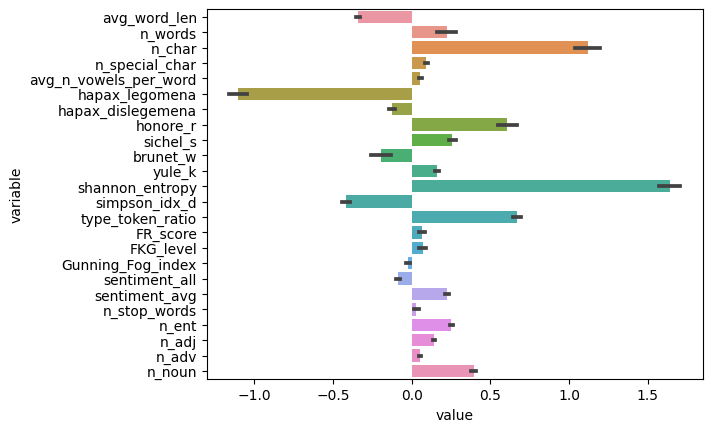

In [152]:
df_coefs = pd.DataFrame(m)
df_coefs.columns = col_use
# df_coefs = np.exp(df_coefs)
sns.barplot(data=df_coefs.melt(), y="variable", x="value")
plt.show()

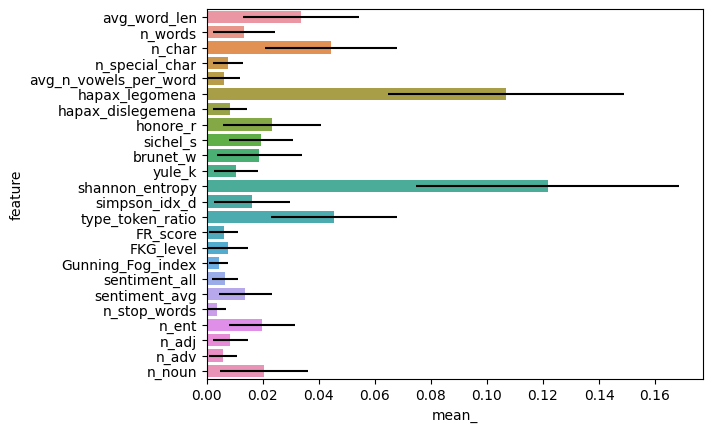

In [40]:
df_per = pd.DataFrame(
    {
        "mean_" : np.abs(p).mean(axis=0), 
        "std_" : np.abs(p).std(axis=0)
    }, index=np.arange(len(col_use)))
df_per["feature"] = col_use
sns.barplot(data=df_per, y="feature", x="mean_", xerr=df_per["std_"])
plt.show()

In [153]:
# df_shap = pd.DataFrame(
#     {
#         "mean_" : np.abs(sh).mean(axis=0), 
#         "std_" : np.abs(sh).std(axis=0)
#     }, index=np.arange(len(col_use)))
# df_shap["feature"] = col_use
# sns.barplot(data=df_shap, y="feature", x="mean_", xerr=df_shap["std_"])
# plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


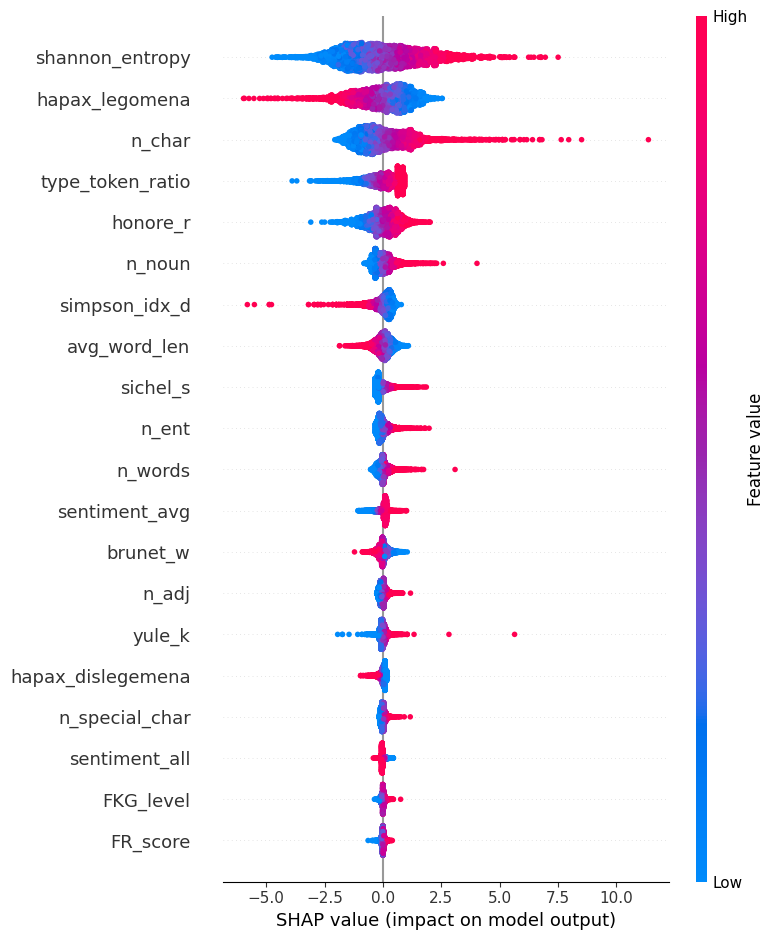

In [154]:
shap.summary_plot(sh, x_sh, feature_names=col_use)

In [159]:
clf_rf = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=0)

In [160]:
out, m, sh, x_sh = run_experiment(X_train[col_use], y_train, cv_fold, clf_rf, None, False, shap.TreeExplainer)
print(
    'styllsitic f rf d2',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

  0%|          | 0/10 [00:00<?, ?it/s]

styllsitic f rf d2 Accuracy 0.609+-0.031 F1 Score 0.571+-0.025  0.609+-0.031 | 0.571+-0.025


In [161]:
# shap.summary_plot(sh, x_sh, feature_names=col_use)

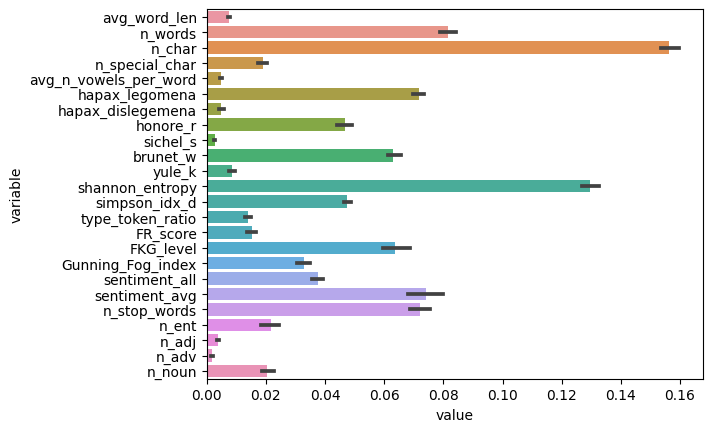

In [162]:
df_coefs = pd.DataFrame(m)
df_coefs.columns = col_use
sns.barplot(data=df_coefs.melt(), y="variable", x="value")
plt.show()

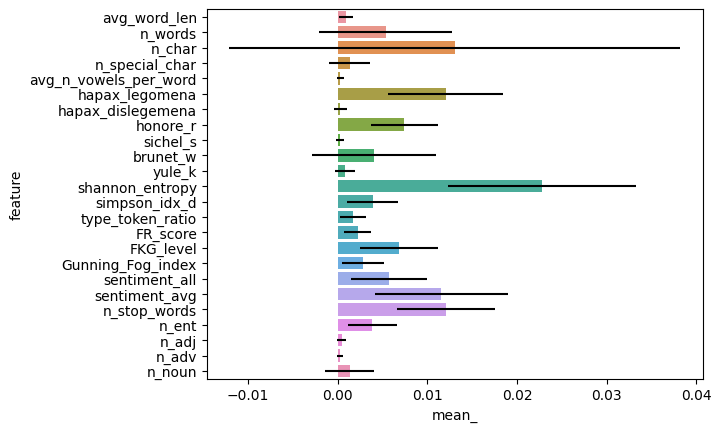

In [163]:
df_shap = pd.DataFrame(
    {
        "mean_" : np.abs(sh).mean(axis=0), 
        "std_" : np.abs(sh).std(axis=0)
    }, index=np.arange(len(col_use)))
df_shap["feature"] = col_use
sns.barplot(data=df_shap, y="feature", x="mean_", xerr=df_shap["std_"])
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


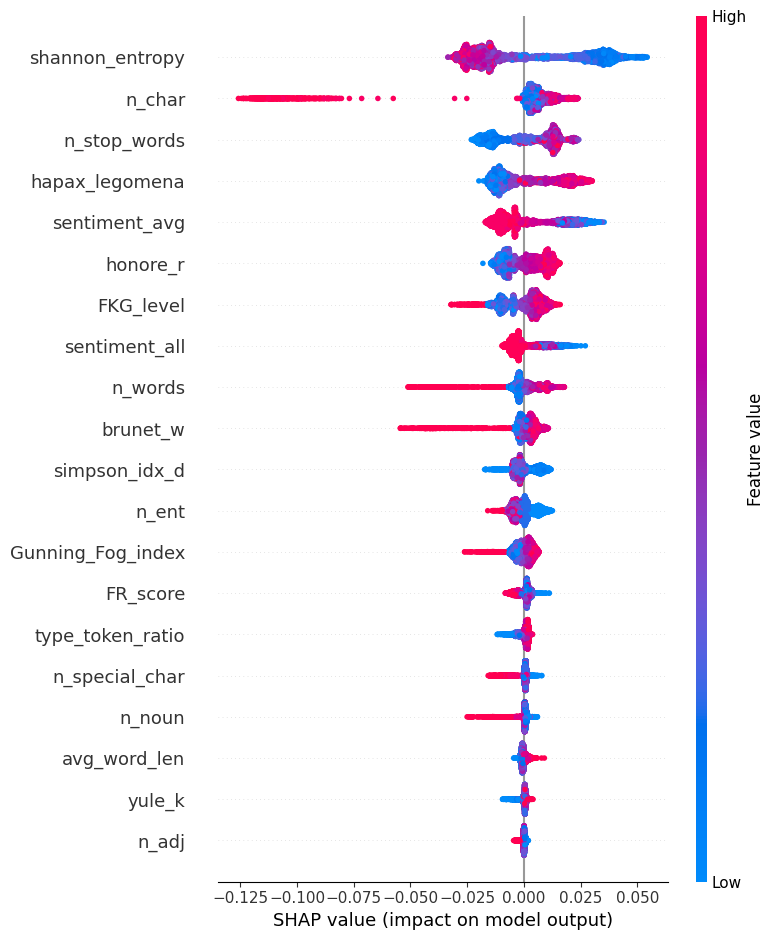

In [164]:
shap.summary_plot(sh, x_sh, feature_names=col_use)

In [171]:
clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=0)

In [173]:
out, m, sh, x_sh = run_experiment(X_train[col_use], y_train, cv_fold, clf_gb, False, False, shap.TreeExplainer)
print(
    'styllsitic f gb',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

  0%|          | 0/10 [00:00<?, ?it/s]

styllsitic f gb Accuracy 0.616+-0.029 F1 Score 0.575+-0.022  0.616+-0.029 | 0.575+-0.022


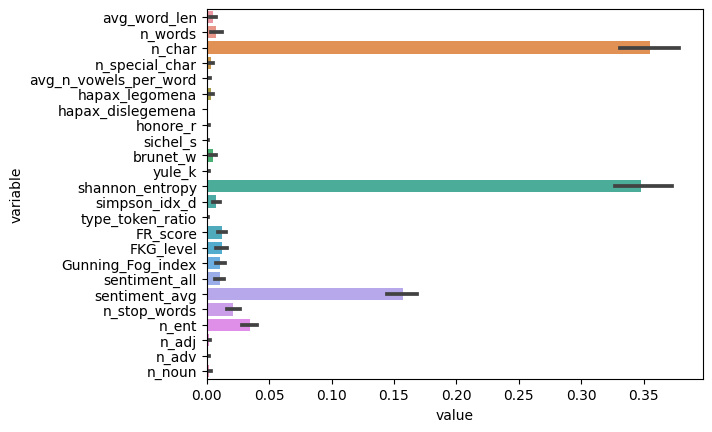

In [174]:
df_coefs = pd.DataFrame(m)
df_coefs.columns = col_use
sns.barplot(data=df_coefs.melt(), y="variable", x="value")
plt.show()

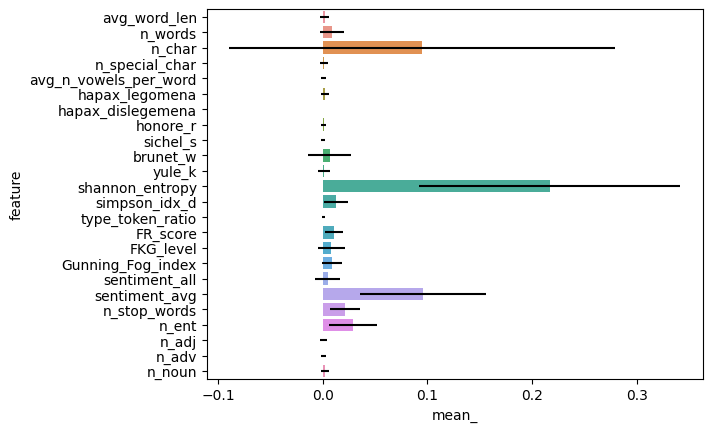

In [175]:
df_shap = pd.DataFrame(
    {
        "mean_" : np.abs(sh).mean(axis=0), 
        "std_" : np.abs(sh).std(axis=0)
    }, index=np.arange(len(col_use)))
df_shap["feature"] = col_use
sns.barplot(data=df_shap, y="feature", x="mean_", xerr=df_shap["std_"])
plt.show()

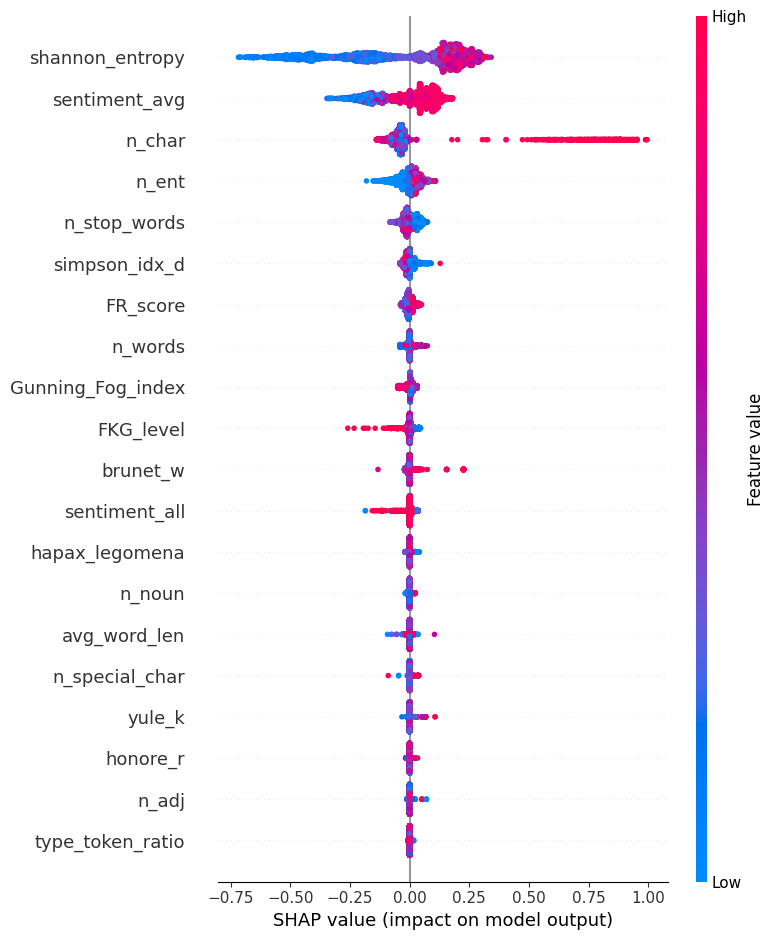

In [177]:
shap.summary_plot(sh, x_sh, feature_names=col_use)

In [41]:
clf_xgb = XGBClassifier(eval_metric='mlogloss', n_estimators=500, max_depth=5, learning_rate=0.001)

In [42]:
out, m, sh, x_sh, p = run_experiment(X_train[col_use], y_train, cv_fold, clf_xgb, False, False, shap.TreeExplainer)
print(
    'styllsitic f xgb',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

  0%|          | 0/10 [00:00<?, ?it/s]

styllsitic f xgb Accuracy 0.617+-0.025 F1 Score 0.601+-0.030  0.617+-0.025 | 0.601+-0.030


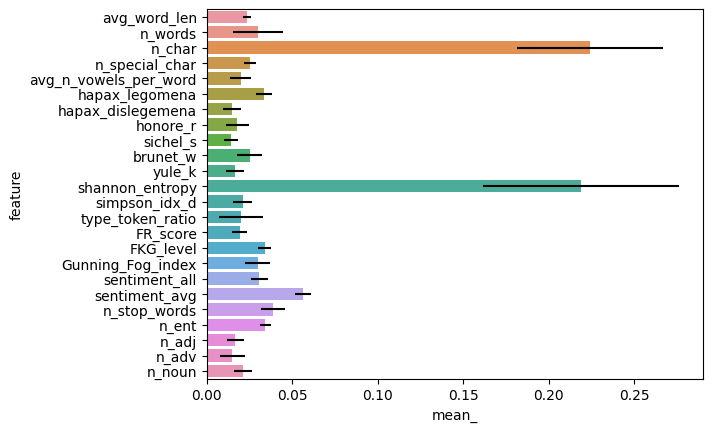

In [46]:
df_imp = pd.DataFrame(
    {
        "mean_" : m.mean(axis=0), 
        "std_" : m.std(axis=0)
    }, index=np.arange(len(col_use)))
df_imp["feature"] = col_use
sns.barplot(data=df_imp, y="feature", x="mean_", xerr=df_imp["std_"])
plt.show()

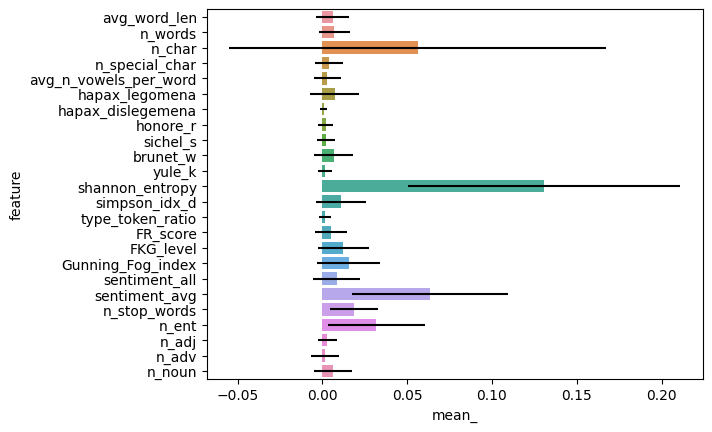

In [43]:
df_shap = pd.DataFrame(
    {
        "mean_" : np.abs(sh).mean(axis=0), 
        "std_" : np.abs(sh).std(axis=0)
    }, index=np.arange(len(col_use)))
df_shap["feature"] = col_use
sns.barplot(data=df_shap, y="feature", x="mean_", xerr=df_shap["std_"])
plt.show()

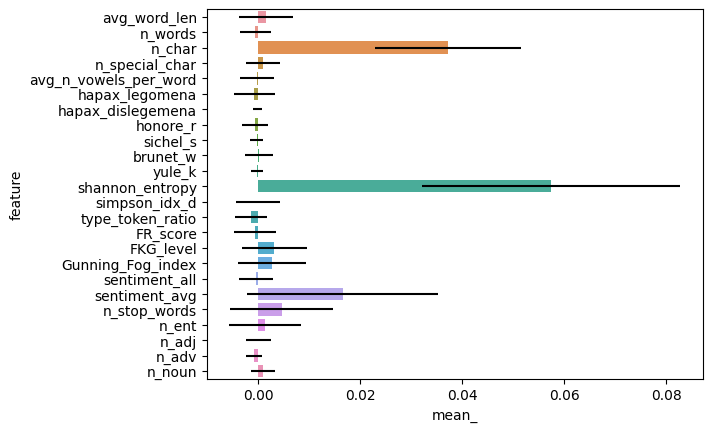

In [47]:
df_per = pd.DataFrame(
    {
        "mean_" : p.mean(axis=0), 
        "std_" : p.std(axis=0)
    }, index=np.arange(len(col_use)))
df_per["feature"] = col_use
sns.barplot(data=df_per, y="feature", x="mean_", xerr=df_per["std_"])
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


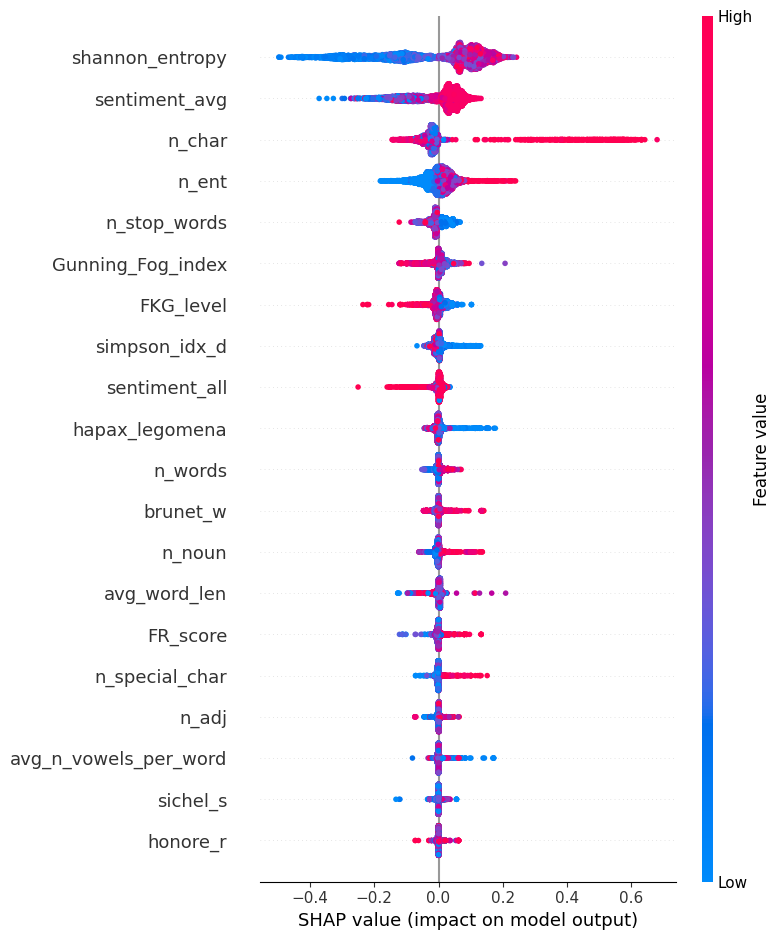

In [49]:
shap.summary_plot(sh, x_sh, feature_names=col_use)

### Combine features

In [182]:
X_all = pd.merge(X_pos.reset_index(drop=True), X_train[col_use].reset_index(drop=True), left_index=True, right_index=True) 

In [184]:
out, m, sh, x_sh = run_experiment(X_all, y_train, cv_fold, clf_lr_1, 'std', True, shap.LinearExplainer)
print(
    'styllsitic f lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

  0%|          | 0/10 [00:00<?, ?it/s]

styllsitic f lr C1 Accuracy 0.633+-0.027 F1 Score 0.542+-0.023  0.633+-0.027 | 0.542+-0.023


In [185]:
out, m, sh, x_sh = run_experiment(X_all, y_train, cv_fold, clf_rf, None, False, shap.TreeExplainer)
print(
    'styllsitic f rf d2',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

  0%|          | 0/10 [00:00<?, ?it/s]

styllsitic f rf d2 Accuracy 0.641+-0.033 F1 Score 0.542+-0.020  0.641+-0.033 | 0.542+-0.020


In [186]:
out, m, sh, x_sh = run_experiment(X_all, y_train, cv_fold, clf_xgb, False, False, shap.TreeExplainer)
print(
    'styllsitic f xgb',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

  0%|          | 0/10 [00:00<?, ?it/s]

styllsitic f xgb Accuracy 0.646+-0.031 F1 Score 0.597+-0.035  0.646+-0.031 | 0.597+-0.035


### Random Kfold

In [187]:
out, m, sh, x_sh = run_experiment(X_all, y_train, cv_Kfold, clf_lr_1, 'std', True, shap.LinearExplainer)
print(
    'styllsitic f lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

  0%|          | 0/10 [00:00<?, ?it/s]

styllsitic f lr C1 Accuracy 0.633+-0.015 F1 Score 0.547+-0.027  0.633+-0.015 | 0.547+-0.027


In [188]:
out, m, sh, x_sh = run_experiment(X_train[col_use], y_train, cv_Kfold, clf_xgb, False, False, shap.TreeExplainer)
print(
    'styllsitic f xgb',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

  0%|          | 0/10 [00:00<?, ?it/s]

styllsitic f xgb Accuracy 0.622+-0.022 F1 Score 0.609+-0.021  0.622+-0.022 | 0.609+-0.021
